In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from einops import rearrange, repeat

from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule

/opt/conda/envs/claymodel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ckpt = "../checkpoints/v0.5.3/mae_v0.5.3_epoch-16_val-loss-0.3086-v1.ckpt" # patch 8 x 8
model = ClayMAEModule.load_from_checkpoint(ckpt, metadata_path="../configs/metadata.yaml", shuffle=True, mask_ratio=0.7)

/opt/conda/envs/claymodel/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
sum(param.numel() for name, param in model.named_parameters())/1000_000

201.08544

In [5]:
model.eval();

In [30]:
dm = ClayDataModule(data_dir="/home/ubuntu/data", size=224, metadata_path="../configs/metadata.yaml", batch_size=1, num_workers=1)

In [31]:
dm.setup(stage="fit")

Total number of chips: 193


In [32]:
trn_dl = dm.train_dataloader()

In [33]:
iter_dl = iter(trn_dl)

In [34]:
l1 = next(iter_dl)
l2 = next(iter_dl)
linz = next(iter_dl)
naip = next(iter_dl)
s1 = next(iter_dl)
s2 = next(iter_dl)

In [35]:
for sensor in (l1, l2, linz, naip, s1, s2):
    print(sensor["platform"], sensor["pixels"].shape)

['landsat-c2l1'] torch.Size([128, 6, 224, 224])
['landsat-c2l2-sr'] torch.Size([128, 6, 224, 224])
['linz'] torch.Size([128, 3, 224, 224])
['naip'] torch.Size([128, 4, 224, 224])
['sentinel-1-rtc'] torch.Size([128, 2, 224, 224])
['sentinel-2-l2a'] torch.Size([128, 10, 224, 224])


In [36]:
def create_input_for_model(sensor, dm, device):
    platform =sensor["platform"][0]
    _sensor = {}
    
    _sensor["pixels"] = sensor["pixels"].to(device)
    _sensor["time"] = sensor["time"].to(device)
    _sensor["latlon"] = sensor["latlon"].to(device)
    _sensor["waves"] = torch.tensor(list(dm.metadata[platform].bands.wavelength.values()))
    _sensor["gsd"] = torch.tensor(dm.metadata[platform].gsd)
    return _sensor

In [37]:
platform = naip["platform"][0]
datacube = create_input_for_model(naip, dm, "cuda")

In [38]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [39]:
unmsk_patch.shape, unmsk_idx.shape, msk_idx.shape, msk_matrix.shape

(torch.Size([128, 237, 768]),
 torch.Size([128, 236]),
 torch.Size([128, 548]),
 torch.Size([128, 784]))

In [40]:
with torch.no_grad():
    pixels, waves = model.model.decoder(unmsk_patch, 
                                        unmsk_idx, 
                                        msk_idx, 
                                        msk_matrix, 
                                        datacube["time"], 
                                        datacube["latlon"], 
                                        datacube["gsd"], 
                                        datacube["waves"])

In [41]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [42]:
mean = list(dm.metadata[platform].bands.mean.values())
std = list(dm.metadata[platform].bands.std.values())

In [43]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [44]:
mean = list(dm.metadata[platform].bands.mean.values())
std = list(dm.metadata[platform].bands.std.values())
datacube_pixels = datacube["pixels"].detach().cpu().numpy()
datacube_pixels = denormalize_images(datacube_pixels, mean, std)
if platform in {"naip", "linz"}:
    datacube_pixels = datacube_pixels.astype(np.uint8)

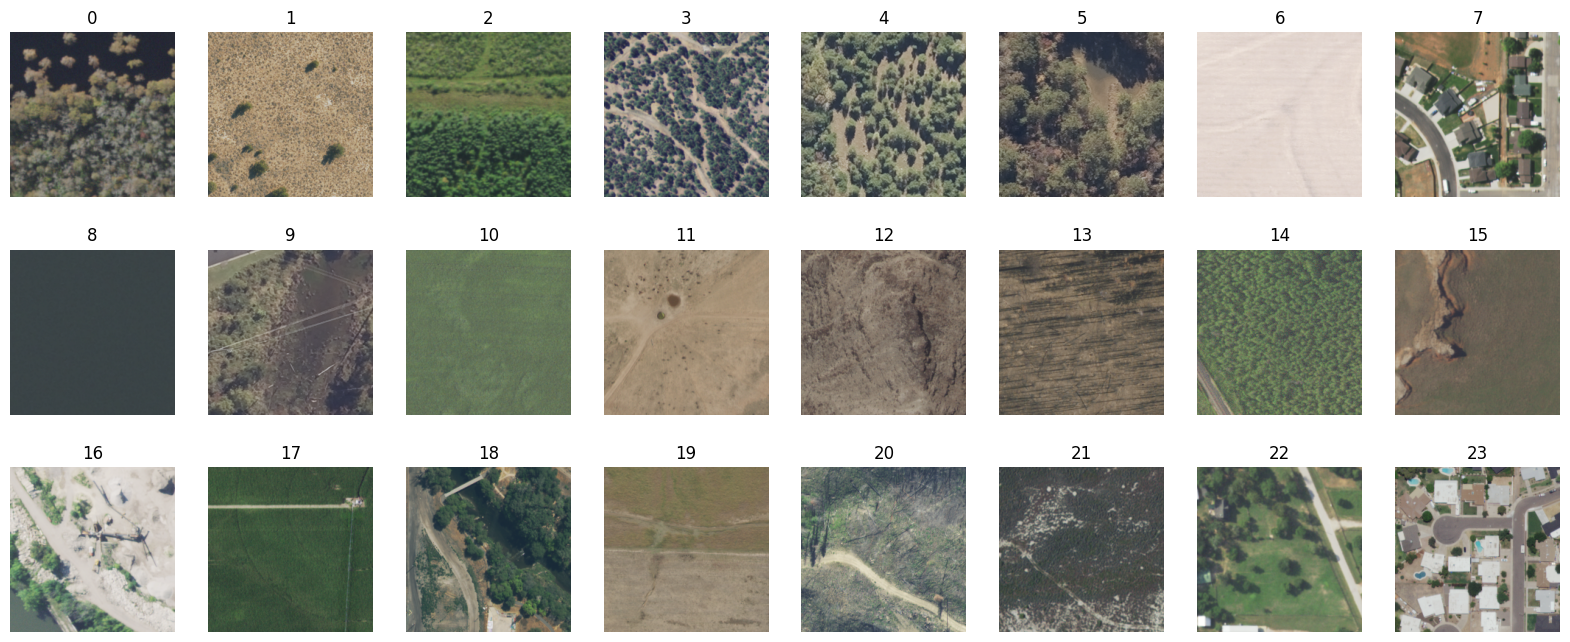

In [45]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(datacube_pixels[idx, :3,...].transpose(1,2,0))
    ax.set_axis_off()
    ax.set_title(idx)

In [46]:
pixels = rearrange(pixels, "b (h w) (c p1 p2) -> b c (h p1) (w p2)", c=datacube_pixels.shape[1], h=28, w=28, p1=8, p2=8)

In [47]:
denorm_pixels = denormalize_images(pixels.cpu().detach().numpy(), mean, std)

In [48]:
if platform in {"naip", "linz"}:
    denorm_pixels = denorm_pixels.astype(np.uint8)

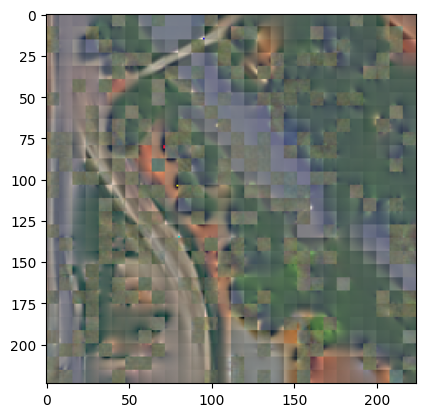

In [68]:
plt.imshow(denorm_pixels[18][[0,1,2], ...].transpose(1,2,0))

In [53]:
msk = rearrange(msk_matrix[17], "(h w) -> h w", h=28).detach().cpu().numpy()

In [54]:
pd.DataFrame(msk).style.format("{:.1f}").background_gradient(cmap="bwr")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
5,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [55]:
upmsk = repeat(
    msk, "h w -> (h repeat_h) (w repeat_w)", repeat_h=8, repeat_w=8
)

In [57]:
chip = datacube_pixels[7][[0,1,2],...]
chip.shape

(3, 224, 224)

In [58]:
msk_chip = (chip * (1 - upmsk)).astype(np.uint8)

In [59]:
msk_chip

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [100, 105, 130, ...,   0,   0,   0],
        [105, 111, 135, ...,   0,   0,   0],
        [101, 107, 128, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [114, 119, 132, ...,   0,   0,   0],
        [113, 119, 131, ...,   0,   0,   0],
        [112, 117, 128, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 75,  80, 101, ...,   0,   0,   0],
        [ 76,  80,  96, ...,   0,   0,   0],
        [ 74,  80,  90, ...,   0,   0,   0]]], dtype=uint8)

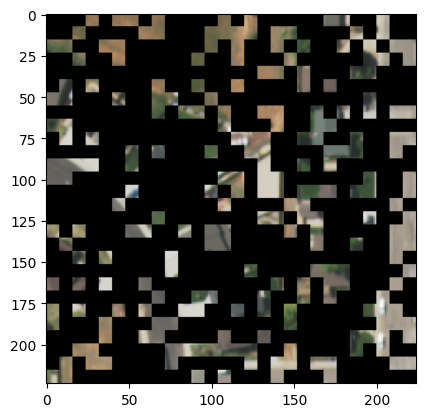

In [60]:
plt.imshow(msk_chip.transpose(1,2,0))

In [61]:
chip_pred = denorm_pixels[20][[0, 1, 2], ...]

In [62]:
chip_pred.shape, upmsk.shape

((3, 224, 224), (224, 224))

In [63]:
unmsk_chip_pred = (chip_pred * upmsk).astype(np.uint8)

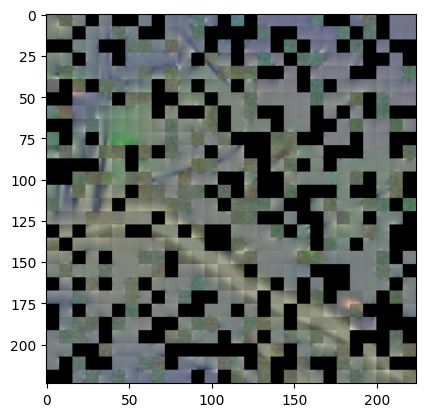

In [64]:
plt.imshow(unmsk_chip_pred.transpose(1,2,0))

In [65]:
chip_final = unmsk_chip_pred + msk_chip

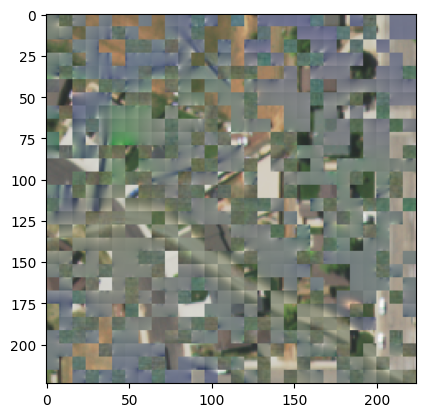

In [66]:
plt.imshow(chip_final.transpose(1,2,0))